# Run meta-analyses on 21 pain studies
Collection of NIDM-Results packs downloaded from Neurovault collection [1425](https://www.neurovault.org/collections/1425/), uploaded by Dr. Camille Maumet.

In [1]:
%matplotlib inline
import json
import numpy as np
from glob import glob
from os.path import basename, join, dirname, isfile
import urllib.request
import os

import pandas as pd
import nibabel as nib
from scipy.stats import t
from nilearn.masking import apply_mask
from nilearn.plotting import plot_stat_map

import nimare
from nimare.meta.ibma import (stouffers, fishers, weighted_stouffers,
                              rfx_glm, ffx_glm)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
url = "https://raw.githubusercontent.com/tsalo/NiMARE/coco2019/download_test_data.py"
u = urllib.request.urlopen(url)
data = u.read()
u.close()

# write python to file
with open("download_test_data.py", "wb") as f:
    f.write(data)

# download the requisite data
from download_test_data import download_dataset
download_dataset()
os.remove("download_test_data.py")

In [3]:
dset_file = join(dirname(nimare.__file__), 'tests', 'data', 'nidm_pain_dset.json')
with open(dset_file, 'r') as fo:
    dset_dict = json.load(fo)
dset = nimare.dataset.Dataset(dset_file)

mask_img = dset.mask

logp_thresh = -np.log(.05)

## Define functions for querying set of NIDM-Results packs

In [4]:
def _get_file(cdict, t):
    """Return the file associated with a given data type within a
    folder if it exists. Otherwise, returns an empty list.
    """
    temp = ''
    if t == 'con':
        temp = cdict['images'].get('con')
    elif t == 'se':
        temp = cdict['images'].get('se')
    elif t == 't':
        temp = cdict['images'].get('t')
    elif t == 'z':
        temp = cdict['images'].get('z')
    elif t == 'n':
        temp = cdict.get('sample_sizes', [])
        if temp:
            temp = np.mean(temp)
    else:
        raise Exception('Input type "{0}" not recognized.'.format(t))

    return temp


def get_files(ddict, types):
    """Returns a list of files associated with a given data type 
    from a set of subfolders within a directory. Allows for
    multiple data types and only returns a set of files from folders
    with all of the requested types.
    """
    all_files = []
    for study in ddict.keys():
        files = []
        cdict = ddict[study]['contrasts']['1']
        for t in types:
            temp = _get_file(cdict, t)
            if temp:
                files.append(temp)
            
        if len(files) == len(types):
            all_files.append(files)
    all_files = list(map(list, zip(*all_files)))
    return all_files

## Get z-maps

In [5]:
files = get_files(dset_dict, ['z'])
z_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in files[0]]
z_data = apply_mask(z_imgs, mask_img)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Fisher's

CPU times: user 1.29 s, sys: 137 ms, total: 1.43 s
Wall time: 1.34 s


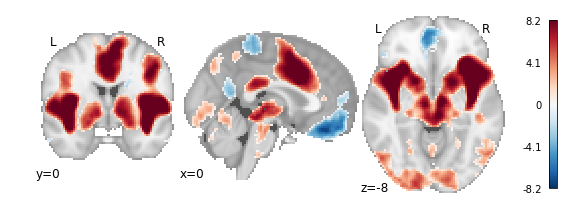

In [6]:
%%time
result = fishers(z_data, mask_img)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

## Stouffer's

### Fixed-effects inference

CPU times: user 1.14 s, sys: 67.1 ms, total: 1.21 s
Wall time: 1.24 s


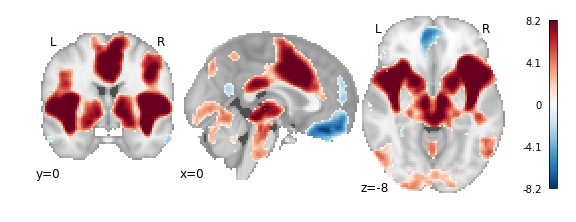

In [7]:
%%time
result = stouffers(z_data, mask_img, inference='ffx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Random-effects inference with theoretical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 1.2 s, sys: 73.6 ms, total: 1.27 s
Wall time: 1.37 s


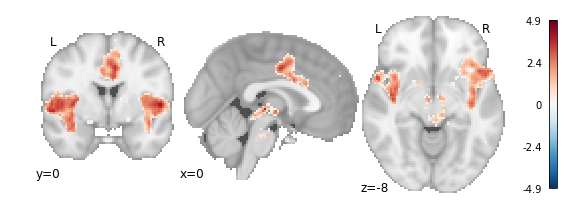

In [8]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='theoretical', n_iters=None)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8], 
              draw_cross=False, cmap='RdBu_r')

### Random-effects inference with empirical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1792: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0
/Users/tsalo/an

CPU times: user 2min 13s, sys: 9.09 s, total: 2min 22s
Wall time: 2min 32s


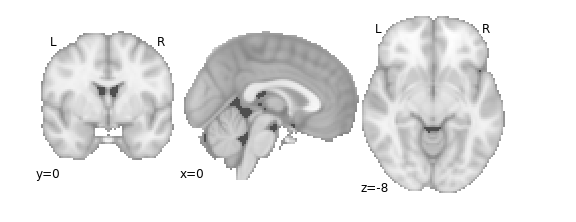

In [9]:
%%time
result = stouffers(z_data, mask_img, inference='rfx',
                   null='empirical', n_iters=1000)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## Get z-maps + sample sizes

In [10]:
z_files, ns = get_files(dset_dict, ['z', 'n'])
z_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in z_files]
z_data = apply_mask(z_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(z_data.shape[0]))

11 studies found.


## Weighted Stouffer's

CPU times: user 935 ms, sys: 54.9 ms, total: 990 ms
Wall time: 918 ms


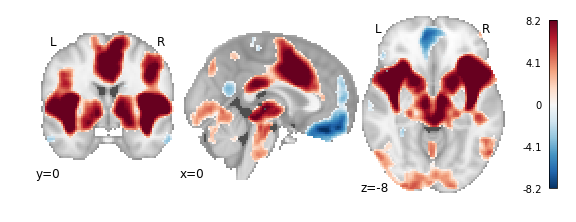

In [11]:
%%time
result = weighted_stouffers(z_data, sample_sizes, mask_img)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## Get contrast maps + contrast standard error maps + sample sizes

In [12]:
con_files, se_files, ns = get_files(dset_dict, ['con', 'se', 'n'])
con_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in con_files]
se_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in se_files]
con_data = apply_mask(con_imgs, mask_img)
se_data = apply_mask(se_imgs, mask_img)
sample_sizes = np.array(ns)
print('{0} studies found.'.format(con_data.shape[0]))

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


21 studies found.


## FFX GLM

190616-15:58:03,490 nipype.interface INFO:
	 stdout 2019-06-16T15:58:03.490535:Log directory is: stats


INFO:nipype.interface:stdout 2019-06-16T15:58:03.490535:Log directory is: stats


190616-15:58:03,496 nipype.interface INFO:
	 stdout 2019-06-16T15:58:03.496623:Setting up:


INFO:nipype.interface:stdout 2019-06-16T15:58:03.496623:Setting up:


190616-15:58:04,379 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.379584:ntptsing=21.000000 


INFO:nipype.interface:stdout 2019-06-16T15:58:04.379584:ntptsing=21.000000 


190616-15:58:04,382 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.379584:


INFO:nipype.interface:stdout 2019-06-16T15:58:04.379584:


190616-15:58:04,391 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.379584:evs_group=1.000000 


INFO:nipype.interface:stdout 2019-06-16T15:58:04.379584:evs_group=1.000000 


190616-15:58:04,406 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.379584:


INFO:nipype.interface:stdout 2019-06-16T15:58:04.379584:


190616-15:58:04,418 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.418673:No f contrasts


INFO:nipype.interface:stdout 2019-06-16T15:58:04.418673:No f contrasts


190616-15:58:04,624 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.624476:


INFO:nipype.interface:stdout 2019-06-16T15:58:04.624476:


190616-15:58:04,629 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.624476:WARNING: The passed in varcope file, /Users/tsalo/Documents/tsalo/NiMARE/examples/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.


INFO:nipype.interface:stdout 2019-06-16T15:58:04.624476:WARNING: The passed in varcope file, /Users/tsalo/Documents/tsalo/NiMARE/examples/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.


190616-15:58:04,638 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.638747:nevs=1


INFO:nipype.interface:stdout 2019-06-16T15:58:04.638747:nevs=1


190616-15:58:04,641 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.638747:ntpts=21


INFO:nipype.interface:stdout 2019-06-16T15:58:04.638747:ntpts=21


190616-15:58:04,654 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.638747:ngs=1


INFO:nipype.interface:stdout 2019-06-16T15:58:04.638747:ngs=1


190616-15:58:04,665 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.638747:nvoxels=189370


INFO:nipype.interface:stdout 2019-06-16T15:58:04.638747:nvoxels=189370


190616-15:58:04,731 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.731654:Running:


INFO:nipype.interface:stdout 2019-06-16T15:58:04.731654:Running:


190616-15:58:04,733 nipype.interface INFO:
	 stdout 2019-06-16T15:58:04.731654:nmaskvoxels=189370


INFO:nipype.interface:stdout 2019-06-16T15:58:04.731654:nmaskvoxels=189370


190616-15:58:07,758 nipype.interface INFO:
	 stdout 2019-06-16T15:58:07.758087: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


INFO:nipype.interface:stdout 2019-06-16T15:58:07.758087: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


190616-15:58:07,762 nipype.interface INFO:
	 stdout 2019-06-16T15:58:07.758087:Saving results


INFO:nipype.interface:stdout 2019-06-16T15:58:07.758087:Saving results


190616-15:58:10,543 nipype.interface INFO:
	 stdout 2019-06-16T15:58:10.543082:


INFO:nipype.interface:stdout 2019-06-16T15:58:10.543082:


190616-15:58:10,545 nipype.interface INFO:
	 stdout 2019-06-16T15:58:10.543082:Log directory was: stats


INFO:nipype.interface:stdout 2019-06-16T15:58:10.543082:Log directory was: stats


190616-15:58:11,499 nipype.interface INFO:
	 stdout 2019-06-16T15:58:11.499033:DLH 0.0310792


INFO:nipype.interface:stdout 2019-06-16T15:58:11.499033:DLH 0.0310792


190616-15:58:11,501 nipype.interface INFO:
	 stdout 2019-06-16T15:58:11.499033:VOLUME 189370


INFO:nipype.interface:stdout 2019-06-16T15:58:11.499033:VOLUME 189370


190616-15:58:11,503 nipype.interface INFO:
	 stdout 2019-06-16T15:58:11.499033:RESELS 152.874


INFO:nipype.interface:stdout 2019-06-16T15:58:11.499033:RESELS 152.874


190616-15:58:11,505 nipype.interface INFO:
	 stdout 2019-06-16T15:58:11.499033:FWHMvoxel 5.04435 5.04435 5.04435


INFO:nipype.interface:stdout 2019-06-16T15:58:11.499033:FWHMvoxel 5.04435 5.04435 5.04435


190616-15:58:11,509 nipype.interface INFO:
	 stdout 2019-06-16T15:58:11.499033:FWHMmm 10.0887 10.6591 11.3728


INFO:nipype.interface:stdout 2019-06-16T15:58:11.499033:FWHMmm 10.0887 10.6591 11.3728


190616-15:58:11,755 nipype.interface INFO:
	 stdout 2019-06-16T15:58:11.755432:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


INFO:nipype.interface:stdout 2019-06-16T15:58:11.755432:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


190616-15:58:11,764 nipype.interface INFO:
	 stdout 2019-06-16T15:58:11.764096:2	66340	0	85.5	11.2	54	2	2	7.73	-8	12.7	1.45	58	-26	22	0.3


INFO:nipype.interface:stdout 2019-06-16T15:58:11.764096:2	66340	0	85.5	11.2	54	2	2	7.73	-8	12.7	1.45	58	-26	22	0.3


190616-15:58:11,773 nipype.interface INFO:
	 stdout 2019-06-16T15:58:11.764096:1	1145	4.7e-05	4.33	5.45	50	-36	-22	53	-40.4	-16.3	0.466	60	-56	-14	0.197


INFO:nipype.interface:stdout 2019-06-16T15:58:11.764096:1	1145	4.7e-05	4.33	5.45	50	-36	-22	53	-40.4	-16.3	0.466	60	-56	-14	0.197


190616-15:58:12,536 nipype.interface INFO:
	 stdout 2019-06-16T15:58:12.535933:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


INFO:nipype.interface:stdout 2019-06-16T15:58:12.535933:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


190616-15:58:12,540 nipype.interface INFO:
	 stdout 2019-06-16T15:58:12.535933:1	524	0.0107	1.97	4.68	-2	-54	10	0.442	-55.1	11.5	0.517	-2	-54	10	0.257


INFO:nipype.interface:stdout 2019-06-16T15:58:12.535933:1	524	0.0107	1.97	4.68	-2	-54	10	0.442	-55.1	11.5	0.517	-2	-54	10	0.257
INFO:nimare.meta.ibma.ibma:Cleaning up...


CPU times: user 5.06 s, sys: 529 ms, total: 5.59 s
Wall time: 14.7 s


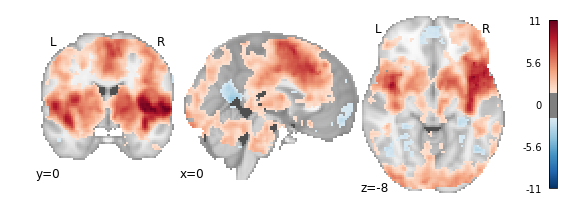

In [13]:
%%time
result = ffx_glm(con_data, se_data, sample_sizes, mask_img)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8], 
              threshold=1.65, draw_cross=False, cmap='RdBu_r')

## Get contrast maps

In [14]:
con_files = get_files(dset_dict, ['con'])
con_files = con_files[0]
con_imgs = [nib.load(join(dirname(nimare.__file__), f)) for f in con_files]
con_data = apply_mask(con_imgs, mask_img)
print('{0} studies found.'.format(con_data.shape[0]))

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


21 studies found.


## RFX GLM

### Theoretical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


CPU times: user 1.14 s, sys: 103 ms, total: 1.24 s
Wall time: 1.3 s


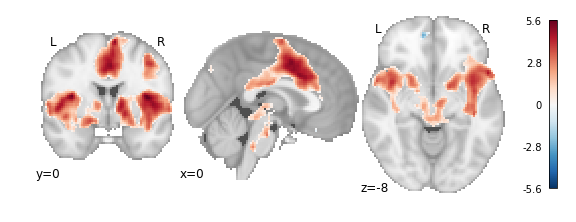

In [15]:
%%time
result = rfx_glm(con_data, mask_img, null='theoretical', n_iters=None)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Empirical null distribution

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1792: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


CPU times: user 2min 27s, sys: 11.8 s, total: 2min 39s
Wall time: 2min 39s


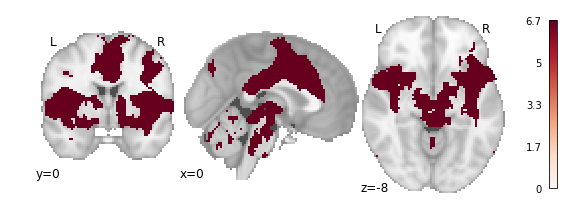

In [16]:
%%time
result = rfx_glm(con_data, mask_img, null='empirical', n_iters=1000)
plot_stat_map(result.images['z'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## MKDA

### Density analysis

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1792: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0
/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/cbma/mkda.py:122: RuntimeWarning: divide by zero encountered in log
  vfwe_map[i_vox] = -np.log(null_to_p(val, perm_max_values, 'upper'))


CPU times: user 12.2 s, sys: 526 ms, total: 12.8 s
Wall time: 20.3 s


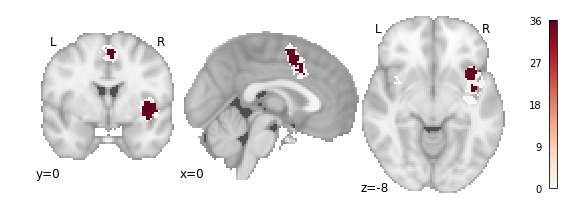

In [17]:
%%time
mkda = nimare.meta.cbma.MKDADensity(dset, kernel__r=10)
mkda.fit(n_iters=10, ids=dset.ids)
plot_stat_map(mkda.results.images['logp_vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FDR correction

/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/cbma/mkda.py:239: RuntimeWarning: invalid value encountered in true_divide
  pFgA = pAgF * pF / pA
/Users/tsalo/Documents/tsalo/NiMARE/nimare/meta/cbma/mkda.py:243: RuntimeWarning: invalid value encountered in true_divide
  pFgA_prior = pAgF * prior / pAgF_prior


CPU times: user 2.62 s, sys: 190 ms, total: 2.81 s
Wall time: 2.86 s


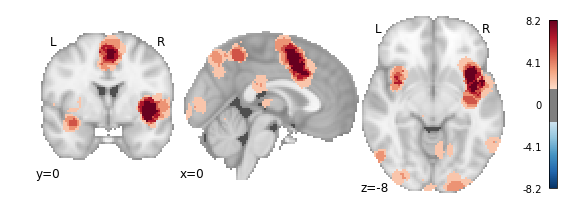

In [18]:
%%time
mkda2 = nimare.meta.cbma.MKDAChi2(dset, kernel__r=10)
mkda2.fit(corr='FDR', ids=dset.ids, ids2=dset.ids)
plot_stat_map(mkda2.results.images['consistency_z'], threshold=1.65, cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

### Chi2 with FWE correction

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1792: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


CPU times: user 22.7 s, sys: 571 ms, total: 23.2 s
Wall time: 29.2 s


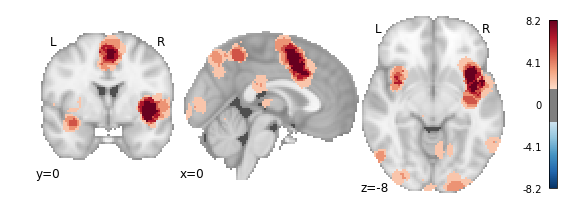

In [19]:
%%time
mkda3 = nimare.meta.cbma.MKDAChi2(dset, kernel__r=10)
mkda3.fit(corr='FWE', n_iters=10, ids=dset.ids, ids2=dset.ids)
plot_stat_map(mkda3.results.images['consistency_z'], threshold=1.65, cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## KDA

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1792: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


CPU times: user 12 s, sys: 290 ms, total: 12.3 s
Wall time: 20 s


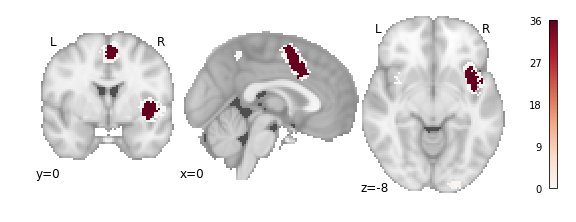

In [21]:
%%time
kda = nimare.meta.cbma.KDA(dset, kernel__r=10)
kda.fit(n_iters=10, ids=dset.ids)
plot_stat_map(kda.results.images['logp_vfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## ALE

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1792: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pct = (np.mean(a_len[idx]) / n) * 100.0


CPU times: user 13.7 s, sys: 627 ms, total: 14.4 s
Wall time: 18.4 s


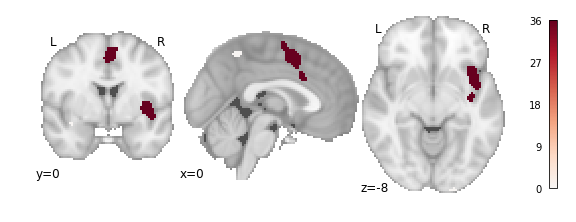

In [22]:
%%time
ale = nimare.meta.cbma.ALE(dset, ids=dset.ids)
ale.fit(n_iters=10, ids=dset.ids)
plot_stat_map(ale.results.images['logp_cfwe'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')

## SCALE

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))


CPU times: user 39.4 s, sys: 10 s, total: 49.4 s
Wall time: 56.3 s


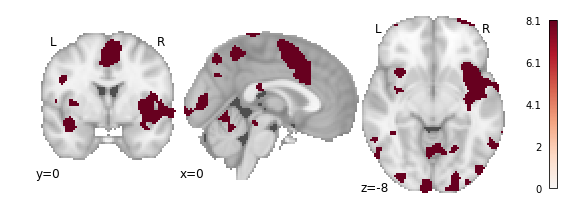

In [23]:
%%time
ijk = np.vstack(np.where(dset.mask.get_data())).T
scale = nimare.meta.cbma.SCALE(dset, ijk=ijk)
scale.fit(n_iters=10, ids=dset.ids)
plot_stat_map(scale.results.images['vthresh'], cut_coords=[0, 0, -8],
              draw_cross=False, cmap='RdBu_r')